# get stimuli timestamp

In [76]:
# This example imports functions from the DemoReadSGLXData module to read
# analog data and convert it to volts based on the metadata information.
# The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq analog channels.
import numpy as np
import matplotlib.pyplot as plt
from toolbox_ap_process import filter_signal
from toolbox_load_data import load_ephyData, load_ttlData

In [77]:
ap_path = 'Z:/data/0_collaboration/ceph_phys/GLC5843/ceph_5843_1_g0/ceph_5843_1_g0_imec0/ceph_5843_1_g0_t0.imec0.ap.bin'
ttl_path = 'Z:/data/0_collaboration/ceph_phys/GLC5843/ceph_5843_1_g0/ceph_5843_1_g0_t0.nidq.bin'
ttl_chan = 1

In [78]:
ttl_data, sRate_ttl, meta_ttl = load_ttlData(ttl_path,ttl_chan)

nChan: 9, nFileSamp: 167160864


In [79]:
stimuli_duration = 1

In [80]:
start_idx = np.min(np.where(ttl_data>20000)[0])-int(sRate_ttl)
foi = ttl_data[start_idx:int(start_idx+520*sRate_ttl)] # a rough frame that contains all grating patch
foi = np.where(foi>20000,30000,0)# ugly way to denoise the frame
stimuli_ontid = np.where(np.diff(foi)==30000)[0][12:]+1+start_idx
stimuli_offtid = stimuli_ontid+sRate_ttl*stimuli_duration

T_before_onset = 5
T_after_offset = 5

tStart =  stimuli_ontid[0]/sRate_ttl - T_before_onset
tEnd = stimuli_offtid[-1]/sRate_ttl + T_after_offset

ttl_target_stim = foi[int(tStart*int(sRate_ttl) - start_idx):int(tEnd*int(sRate_ttl) - start_idx)]

tID_stim_on = (stimuli_ontid - stimuli_ontid[0] + int(sRate_ttl)*T_before_onset).astype(int)
tID_stim_off = (stimuli_offtid - stimuli_ontid[0] + int(sRate_ttl)*T_before_onset).astype(int)

tStimOnset = tID_stim_on/int(sRate_ttl)
tStimOffset = tID_stim_off/int(sRate_ttl)

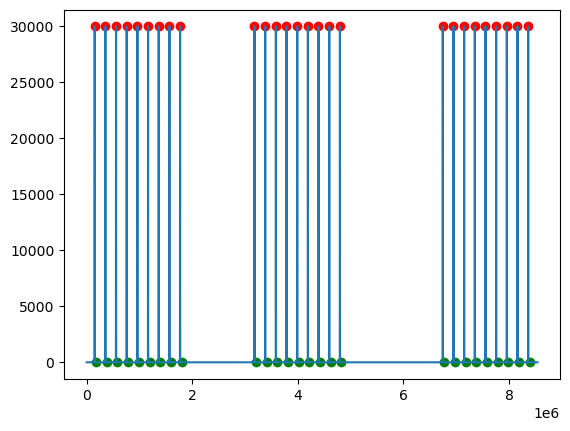

In [6]:
## crop the stimuli frame: we only care about what happened (1s before onset~1s after all stimuli delivered)  
plt.plot(ttl_target_stim)
plt.scatter(tID_stim_on, ttl_target_stim[tID_stim_on],color='red')
plt.scatter(tID_stim_off, ttl_target_stim[tID_stim_off],color='green')

In [7]:
plt.close('all')

# load raw data (neuropixel)

In [81]:
# Other parameters about what data to read
## only use the frame we plotted
chanList = np.arange(80,120)    # list of channels to extract, by index in saved file

In [82]:

selectData_ap,sRate_ap,meta_ap = load_ephyData(ap_path, tStart, tEnd, chanList)


nChan: 385, nFileSamp: 167146363


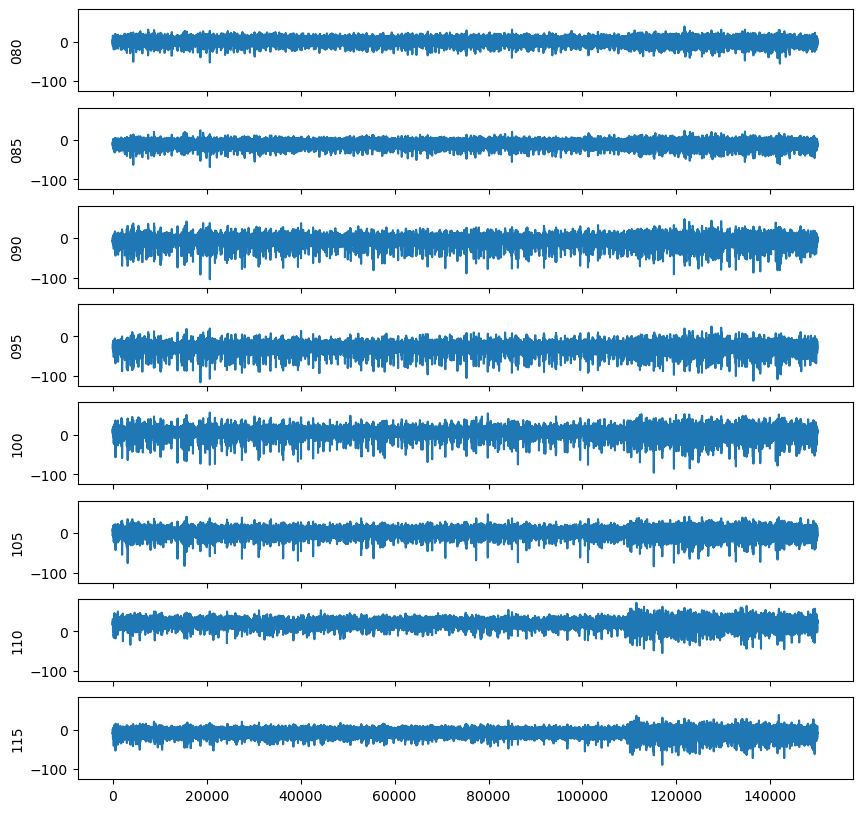

In [14]:
sample_interval = 5
fig, axes = plt.subplots(nrows=int(len(selectData_ap)/sample_interval),ncols=1,sharex=True, sharey=True, figsize = (10,10))
for i,chanid in enumerate(np.arange(0,len(selectData_ap),sample_interval)):
    axes[i].plot(selectData_ap[chanid][int(15*sRate_ap):int(20*sRate_ap)])
    axes[i].set_ylabel('%03d'%(chanid+80))
    # axes[i].set_xticks(np.arange(0,5,5)*sRate,np.arange(0,25,5))
# plt.savefig('rawData_timeframe_lfp.png')

In [38]:
print('start time %.2f s'%tStart)

start time 3811.26 s


# preprocess data 
## Step1: filter signal

In [83]:
xf = filter_signal(selectData_ap, sRate_ap, 500, 4000)

In [15]:
#np.save('filteredData_grating_patch.npy',xf)

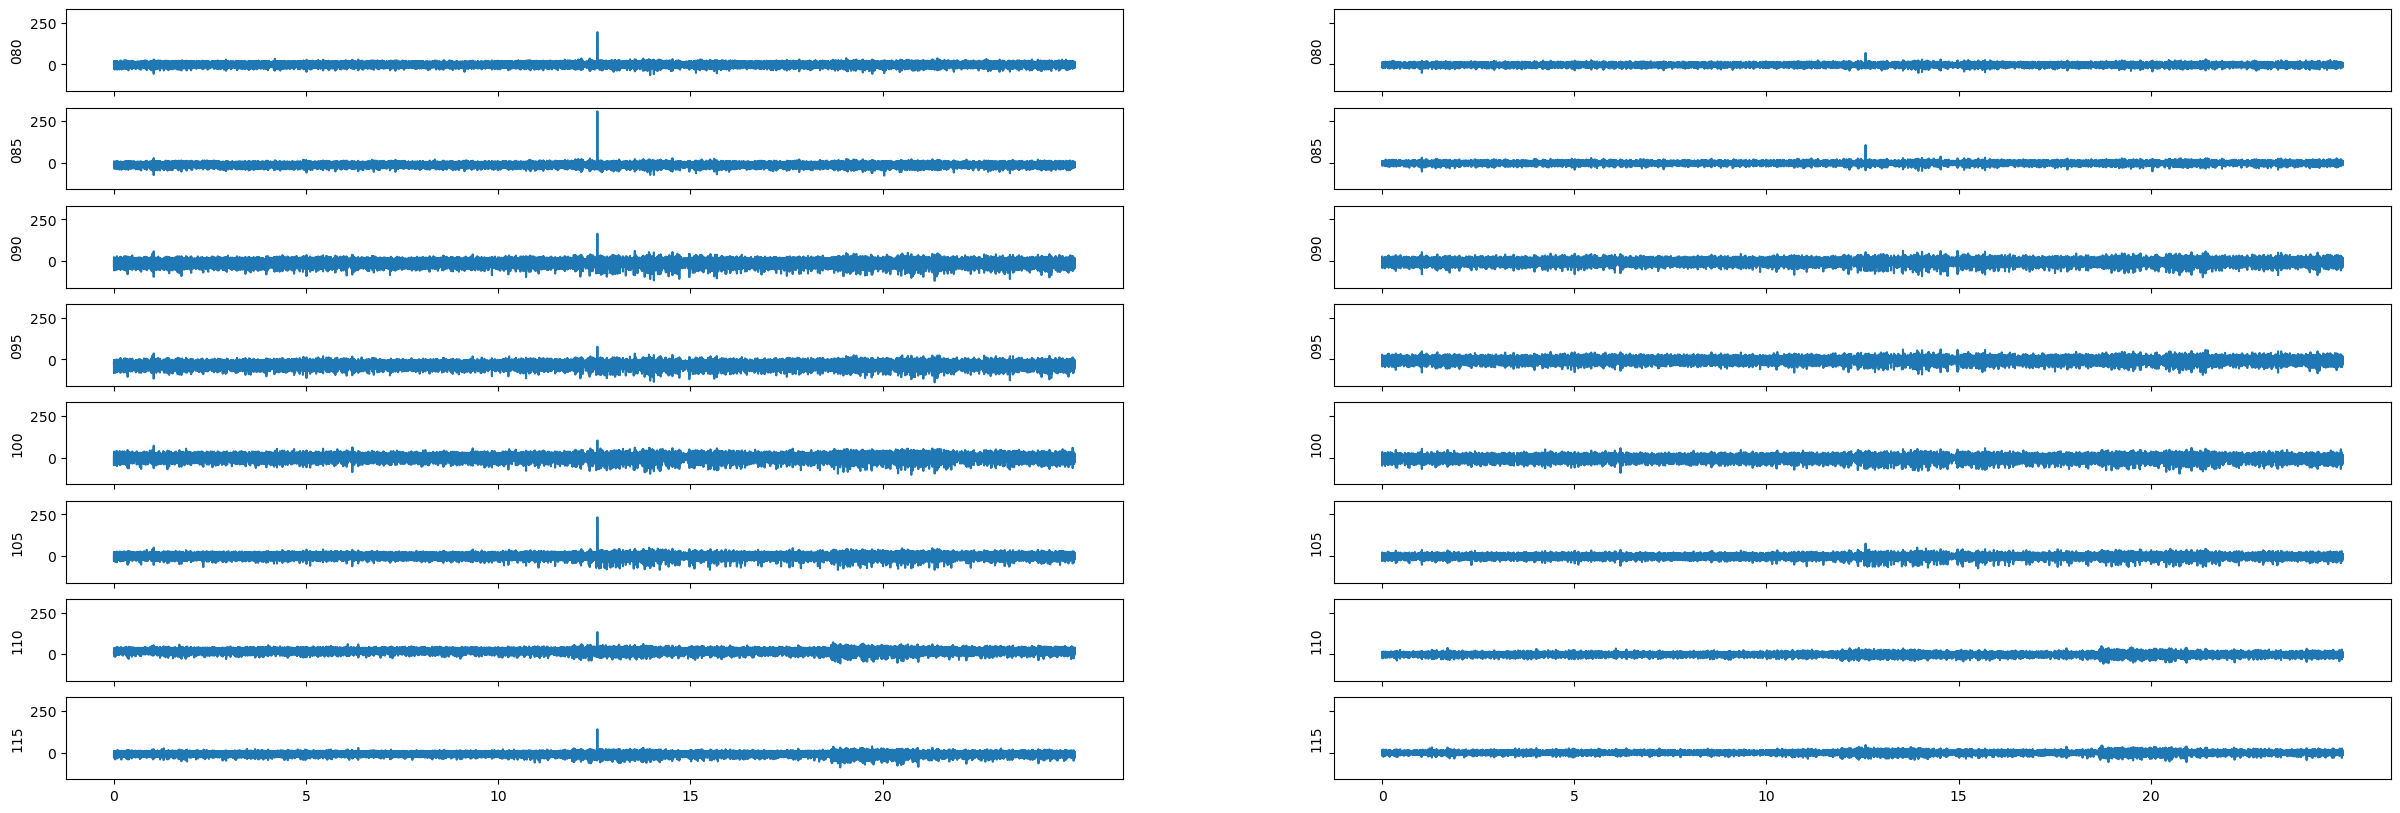

In [11]:
sample_interval = 5
fig, axes = plt.subplots(nrows=int(len(xf)/sample_interval),ncols=2,figsize = (30,10),sharex=True,sharey=True)
for i,chanid in enumerate(np.arange(0,len(xf),sample_interval)):
    axes[i,0].plot(selectData_ap[chanid][:int(25*sRate_ap)])
    axes[i,0].set_ylabel('%03d'%(chanid+chanList[0]))
    axes[i,0].set_xticks(np.arange(0,25,5)*sRate_ap,np.arange(0,25,5))
    axes[i,1].plot(xf[chanid][:int(25*sRate_ap)])
    axes[i,1].set_ylabel('%03d'%(chanid+chanList[0]))
    axes[i,1].set_xticks(np.arange(0,25,5)*sRate_ap,np.arange(0,25,5))
#plt.savefig('filtered_Data_timeframe_uV.png')

## Step2: detect AP

In [85]:
from toolbox_ap_process import detect_spikes

In [163]:
# xf = np.load('filteredData_grating_patch.npy',allow_pickle=True)

In [86]:
(s, t), threshold, s_all, nSpk = detect_spikes(xf, sRate_ap, N=4,lockout=1)
print('from chan %03d to %03d: found %d spikes with th %.2f'%(chanList[0],chanList[-1],len(s_all),threshold))

from chan 080 to 119: found 588508 spikes with th -18.64


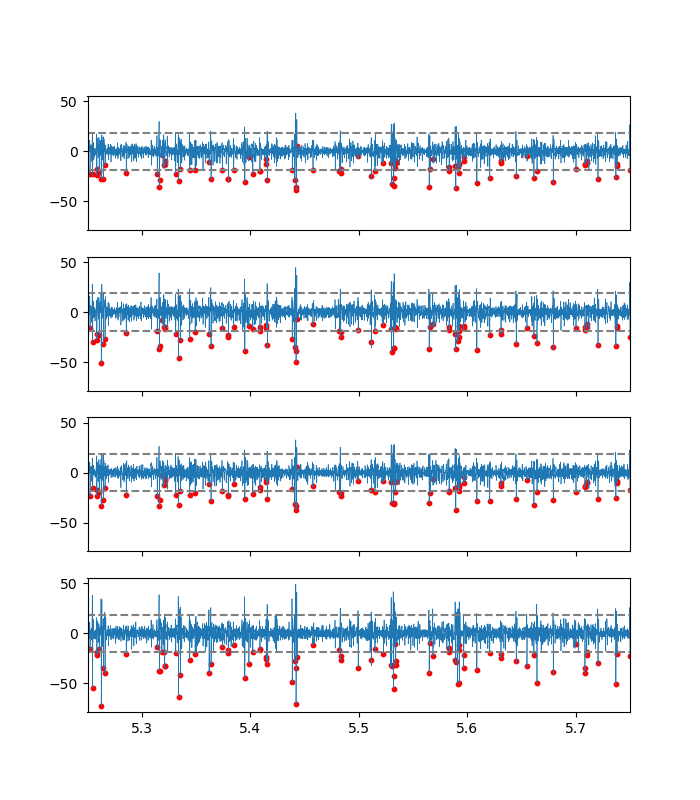

In [224]:
# fig, axes = plt.subplots(nrows=4,ncols=1,sharey = True, sharex=True, figsize = (7,8))
# start_time = 5.25
# stop_time = 5.75
# time_series = np.arange(start_time, stop_time, step=1/sRate_ap)
# %matplotlib widget
# from ipywidgets import interact
# (s_sample, t_sample), threshold_sample, s_all_sample, s_counts = detect_spikes(xf[11:15], sRate_ap, N=4, lockout=1)
# peak_times = t_sample[np.where((t_sample<(stop_time*1000))&(t_sample>(start_time*1000)))[0]]/1000
# for i,chanid in enumerate(np.arange(11,15)):
#     axes[i] = plot_peaks(axes[i], time_series,  xf[chanid], sRate_ap, peak_times, threshold)

# #plt.savefig('detected_spks_Data_timeframe_uV.png')

In [227]:
%matplotlib inline
plt.close('all')

# normalize data 

In [87]:
%matplotlib inline

from toolbox_ap_process import get_spkTrain

In [88]:
spike_counts, bin_size = get_spkTrain(t)

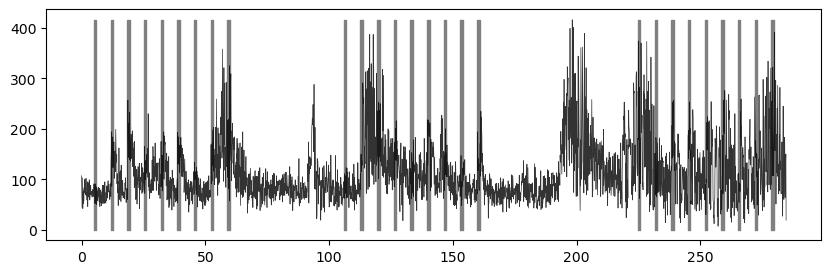

In [89]:
time_series = np.linspace(0,tEnd-tStart,len(spike_counts))
tStimOnset = tStimOnset.flatten()
tStimOffset = tStimOffset.flatten()

plt.figure(figsize=(10,3))
for i in range(len(tStimOnset)):
    plt.fill_betweenx([0,np.max(spike_counts)], tStimOnset[i], tStimOffset[i], color="grey", alpha=1)
plt.plot(time_series, spike_counts,color='black',linewidth=.5,alpha=.8)



In [255]:
stimuli_duration = 1

In [90]:
nSpk_ONset=np.zeros((len(tStimOnset),int(1000*stimuli_duration/bin_size)))
nSpk_OFFset=np.zeros((len(tStimOnset),int(1000*stimuli_duration/bin_size)))

for i in range(len(tStimOnset)):
    nSpk_ONset[i] = spike_counts[int(tStimOnset[i]*1000*stimuli_duration/bin_size):int(tStimOffset[i]*1000*stimuli_duration/bin_size)]
    nSpk_OFFset[i] = spike_counts[int((tStimOnset[i]-1)*1000*stimuli_duration/bin_size):int(tStimOnset[i]*1000*stimuli_duration/bin_size)]
    

In [91]:
nSpk_ONset_pos = nSpk_ONset.reshape(3,9,int(1000/bin_size))
nSpk_OFFset_pos = nSpk_OFFset.reshape(3,9,int(1000/bin_size))

In [128]:
nSpk_ONset_pos_500ms = nSpk_ONset_pos[:,:,int(500*stimuli_duration/bin_size):].mean(axis=2)
nSpk_OFFset_pos_500ms = nSpk_OFFset_pos[:,:,int(500*stimuli_duration/bin_size):].mean(axis=2)
diff_Spk = nSpk_ONset_pos_500ms - nSpk_OFFset_pos_500ms
normalized_Spk = np.mean(diff_Spk,axis=0)


In [ ]:
diff_Spk = (nSpk_ONset_pos - nSpk_OFFset_pos).mean(axis=2)


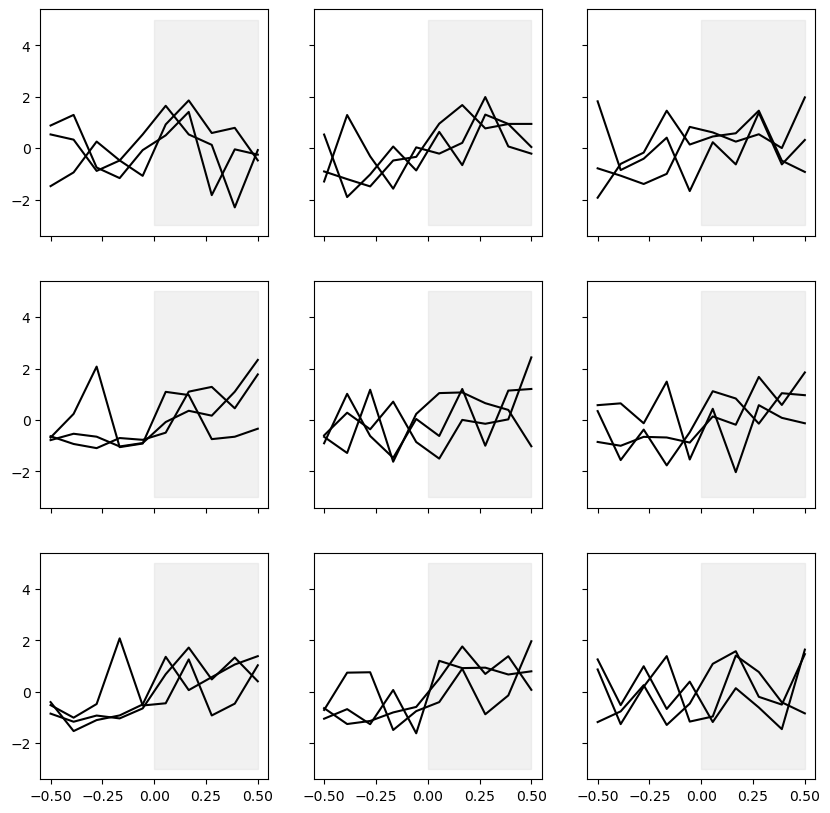

In [254]:

time_series = np.tile(np.linspace(-.5,.5,int(1000/bin_size)),nSpk_OFFset_pos.shape[0]).reshape((nSpk_OFFset_pos.shape[0],int(1000/bin_size)))
fig, axes = plt.subplots(nrows=3,ncols=3,sharey = True, sharex=True, figsize = (10,10))
for i in range(9):    
    d = np.concatenate([nSpk_OFFset_pos[:,i,-int(500/bin_size):].T,nSpk_ONset_pos[:,i,-int(500/bin_size):].T],axis=0)
    d = (d - d.mean(axis=0))/d.std(axis=0)
    row, col = i%3,i//3
    axes[row,col].plot(time_series.T,d,c='black')
    axes[row,col].fill_betweenx([-3,5],0,np.max(time_series),color="lightgrey", alpha=.3)
    

In [98]:
from toolbox_plot import get_colors,get_cm, plot_multiple_rawdata
from toolbox_ap_process import prepare_rawData_condition, find_stimModulated_channel

In [130]:
cm = get_cm()
colors = get_colors(cm, normalized_Spk)

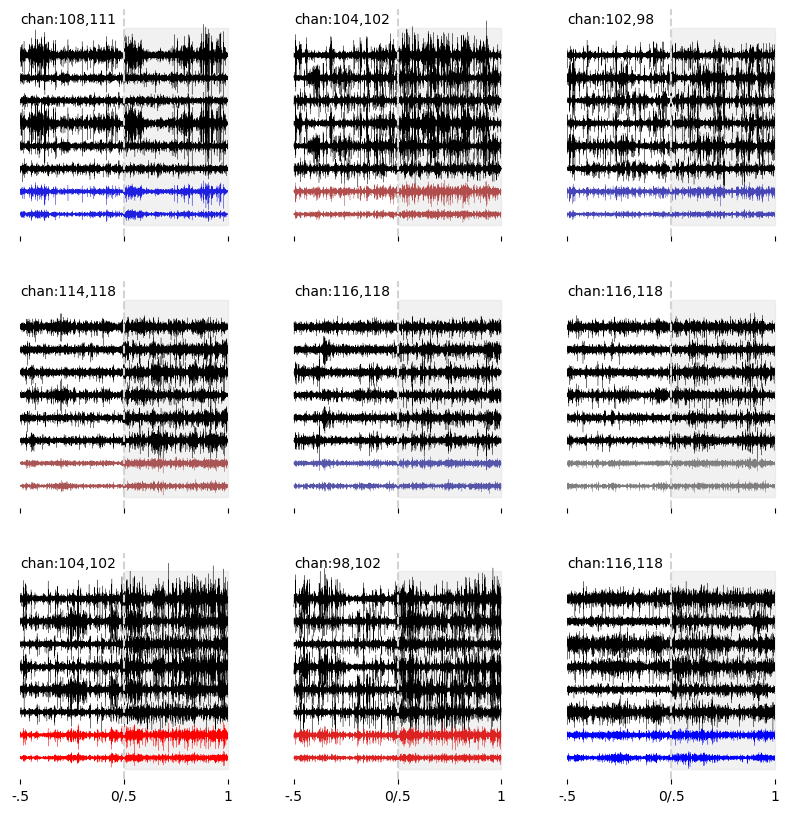

In [140]:
#coi = np.argsort(nSpk)[-2:]
tStimOnset_cond = tStimOnset.reshape((3,9))
tStimOffset_cond = tStimOffset.reshape((3,9))
stim_duration = .5
time_axis = np.arange(-stim_duration,stim_duration,step=1/sRate_ap)


fig, axes = plt.subplots(nrows=3,ncols=3,sharey = True, sharex=True, figsize = (10,10))
for i in range(tStimOnset_cond.shape[1]):
    start_time_stim = tStimOnset_cond[:,i] + stim_duration
    stop_time_stim = tStimOffset_cond[:,i]
    vol_data_stim = prepare_rawData_condition(xf, start_time_stim, stop_time_stim, sRate_ap)
    voi_stim_average = vol_data_stim.mean(axis=1).mean(axis=0)
    
    start_time_base = tStimOnset_cond[:,i] - stim_duration
    stop_time_base = tStimOnset_cond[:,i]
    vol_data_base = prepare_rawData_condition(xf, start_time_base, stop_time_base, sRate_ap) 
    voi_base_average = vol_data_base.mean(axis=1).mean(axis=0)
    
    coi = find_stimModulated_channel(vol_data_stim, vol_data_base, 2)
    
    vol_stim_selected = vol_data_stim[coi,:,:].reshape((-1, ) + vol_data_stim.shape[2:])
    vol_base_selected = vol_data_base[coi,:,:].reshape((-1, ) + vol_data_stim.shape[2:])
    
    vol_data = np.concatenate([vol_base_selected, vol_stim_selected],axis=1)
    
    avg_data = np.concatenate([voi_base_average, voi_stim_average])
    avg_data = np.vstack([vol_data.mean(axis=0),avg_data])
    row, col = i%3,i//3
    axes[row,col],data_arr = plot_multiple_rawdata(axes[row,col], time_axis, vol_data, avg_data, sRate_ap, colors[i],coi+chanList[0], 60)
    

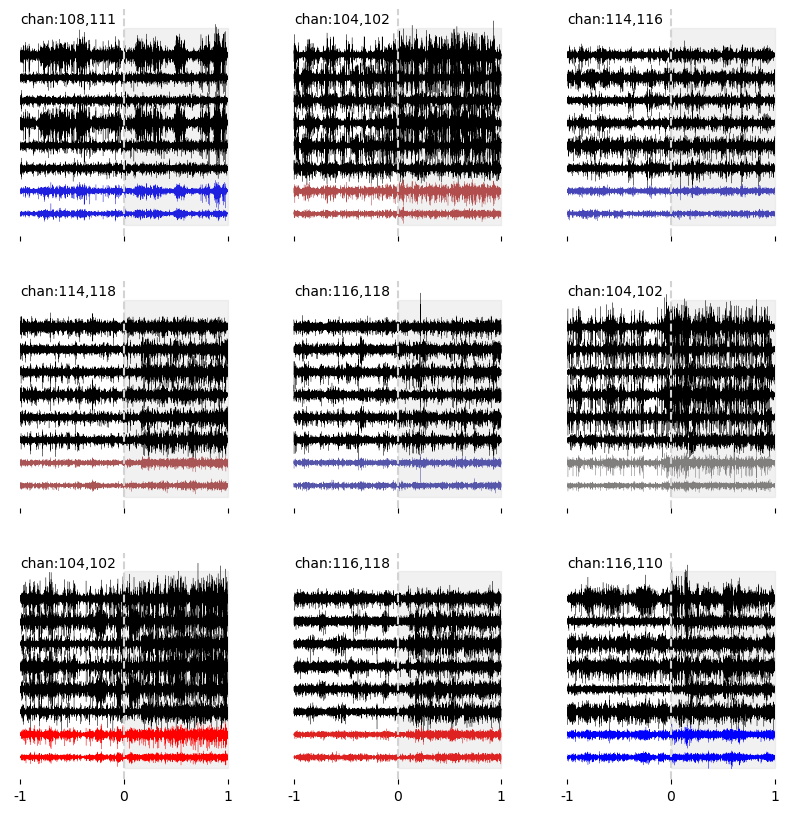

In [142]:
#coi = np.argsort(nSpk)[-2:]
tStimOnset_cond = tStimOnset.reshape((3,9))
tStimOffset_cond = tStimOffset.reshape((3,9))
stim_duration = 1
time_axis = np.arange(-stim_duration,stim_duration,step=1/sRate_ap)


fig, axes = plt.subplots(nrows=3,ncols=3,sharey = True, sharex=True, figsize = (10,10))
for i in range(tStimOnset_cond.shape[1]):
    start_time_stim = tStimOnset_cond[:,i]
    stop_time_stim = tStimOffset_cond[:,i]
    vol_data_stim = prepare_rawData_condition(xf, start_time_stim, stop_time_stim, sRate_ap)
    voi_stim_average = vol_data_stim.mean(axis=1).mean(axis=0)
    
    start_time_base = tStimOnset_cond[:,i] - stim_duration
    stop_time_base = tStimOnset_cond[:,i]
    vol_data_base = prepare_rawData_condition(xf, start_time_base, stop_time_base, sRate_ap) 
    voi_base_average = vol_data_base.mean(axis=1).mean(axis=0)
    
    coi = find_stimModulated_channel(vol_data_stim, vol_data_base, 2)
    
    vol_stim_selected = vol_data_stim[coi,:,:].reshape((-1, ) + vol_data_stim.shape[2:])
    vol_base_selected = vol_data_base[coi,:,:].reshape((-1, ) + vol_data_stim.shape[2:])
    
    vol_data = np.concatenate([vol_base_selected, vol_stim_selected],axis=1)
    
    avg_data = np.concatenate([voi_base_average, voi_stim_average])
    avg_data = np.vstack([vol_data.mean(axis=0),avg_data])
    row, col = i%3,i//3
    axes[row,col],data_arr = plot_multiple_rawdata(axes[row,col], time_axis, vol_data, avg_data, sRate_ap, colors[i],coi+chanList[0], 60, time_label=['-1','0','1'])
    